In [7]:
from qiskit.opflow import StateFn, PauliExpectation, Zero, One,Z,X,I,PauliOp, PauliSumOp
from qiskit import QuantumCircuit,QuantumRegister,Aer, assemble
from qiskit.opflow.state_fns import CircuitStateFn
from qiskit.quantum_info.operators import Operator, Pauli

from qiskit.circuit import Parameter
from qiskit import Aer,transpile
from qiskit.utils import QuantumInstance
from qiskit.opflow.converters import CircuitSampler
from math import *
import numpy as np
import matplotlib.pyplot as plt
# 
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, BravyiKitaevMapper , ParityMapper
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SLSQP,L_BFGS_B
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver

from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian

from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers import FreezeCoreTransformer,BaseTransformer
from sympy import symbols
from qiskit_nature.algorithms import VQEUCCFactory,GroundStateEigensolver
svsim = Aer.get_backend('aer_simulator')
import scipy


In [8]:
# import the modified pieces of Natural gradient to perform an imaginary time evolution
from qiskit_mod.qiskit_ter import LinCombFullmod,NewNaturalGradient

In [9]:
# Initialize qubit converter
qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True) #two qubit reduction doesn`t work with Jordan-Wigner

# Initialize Exact solvers & VQE solver
numpy_solver = NumPyMinimumEigensolver()

quantum_instance = QuantumInstance(backend = Aer.get_backend('statevector_simulator'))

optimizer = L_BFGS_B(maxiter=1000)

# choose a distance to test
bond_distance= 0.75

# Set the Hydrogen molecule
molecule = 'H .0 .0 -{0}; H .0 .0 {0}'
driver = PySCFDriver(atom = molecule.format(bond_distance/2), unit=UnitsType.ANGSTROM, basis='sto3g')

es_problem = ElectronicStructureProblem(driver)  

# Get the qubit Hamiltonian
second_q_op = es_problem.second_q_ops()
qubit_op = qubit_converter.convert(second_q_op[0], num_particles=es_problem.num_particles)
print('The qubit Hamiltonian: \n',qubit_op)

# Separate coefficients from Pauli operators in the Hamilt.
char_list = str(qubit_op).split()
hamil_parts= [ c for c in char_list if c.isalpha()]
dict_coeff={}
for i in range(len(qubit_op.coeffs)):
	dict_coeff[i] = np.real(qubit_op.coeffs[i])

print("Coefficients:", dict_coeff,"\n Pauli Op.:", hamil_parts)


The qubit Hamiltonian: 
 (-1.0554030320779284-2.7755575615628914e-17j) * II
+ (-0.3887475880915992-1.3877787807814457e-17j) * ZI
+ (0.3887475880915992+2.7755575615628914e-17j) * IZ
- 0.01117714476252557 * ZZ
+ 0.18177153657730488 * XX
Coefficients: {0: -1.0554030320779284, 1: -0.3887475880915992, 2: 0.3887475880915992, 3: -0.01117714476252557, 4: 0.18177153657730488} 
 Pauli Op.: ['II', 'ZI', 'IZ', 'ZZ', 'XX']


In [10]:
# Find ground state for comparison (both VQE and exact)

# Initialize VQE solver
vqe_solver = VQEUCCFactory(quantum_instance, optimizer=optimizer)
calc = GroundStateEigensolver(qubit_converter, vqe_solver)
res = calc.solve(es_problem)
vqe_energies = res.total_energies
print('Ground state energy from VQE ',vqe_energies)

# Initialize Exact solvers 
numpy_solver = NumPyMinimumEigensolver()  # exact numpy solver
exact_calc = GroundStateEigensolver(qubit_converter, numpy_solver)
res_exact = exact_calc.solve(es_problem)
exact_energy = res_exact.total_energies
print('Ground state energy from numpy solver ',exact_energy)

Ground state energy from VQE  [-1.13711707]
Ground state energy from numpy solver  [-1.13711707]


In [11]:
def universal_ansatz(params) -> QuantumCircuit:
	ua = QuantumCircuit(2)
	ua.ry(params[0],0)
	ua.rz(params[1],0)

	ua.ry(params[2],1)
	ua.rz(params[3],1)

	ua.cnot(0,1)

	ua.ry(params[4],0)
	ua.rz(params[5],0)

	ua.ry(params[6],1)
	ua.rz(params[7],1)
	return ua



def measure_H_energy(sampler, angles, hamiltonian) -> float:
	ua = universal_ansatz(angles)
	measurement=StateFn(hamiltonian, is_measurement=True)#.adjoint()
	final_circuit=measurement@CircuitStateFn(ua)
	PE = PauliExpectation().convert(final_circuit)
	out=sampler.convert(PE)
	return out.eval()

def measure_circuit(circ,sampler,use_shots=False) -> float:
	if use_shots==True:
		shots=1024
		qobj = assemble(circ)  	 #Assemble circuit into a Qobj that can be run
		counts = simulator.run(qobj,shots=shots).result().get_counts()  # Do the simulation
		if '0' not in counts: counts['0']=0
		if '1' not in counts: counts['1']=0
		res=(counts['0']-counts['1'])/shots
		
	else:
		circ.save_statevector()
		#qobj = assemble(circ)
		# Transpile the circuit for the noisy basis gates
		qobj = transpile(circ, sampler)
		statev = simulator.run(qobj,shots=1).result().get_statevector()
		sqr=statev**2
		res=sum(abs(sqr[0::2]))-sum(abs(sqr[1::2]))
	return res



/home/gsilvi/miniforge3/envs/NEASQC4/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


ValueError: x and y must have same first dimension, but have shapes (500,) and (501,)

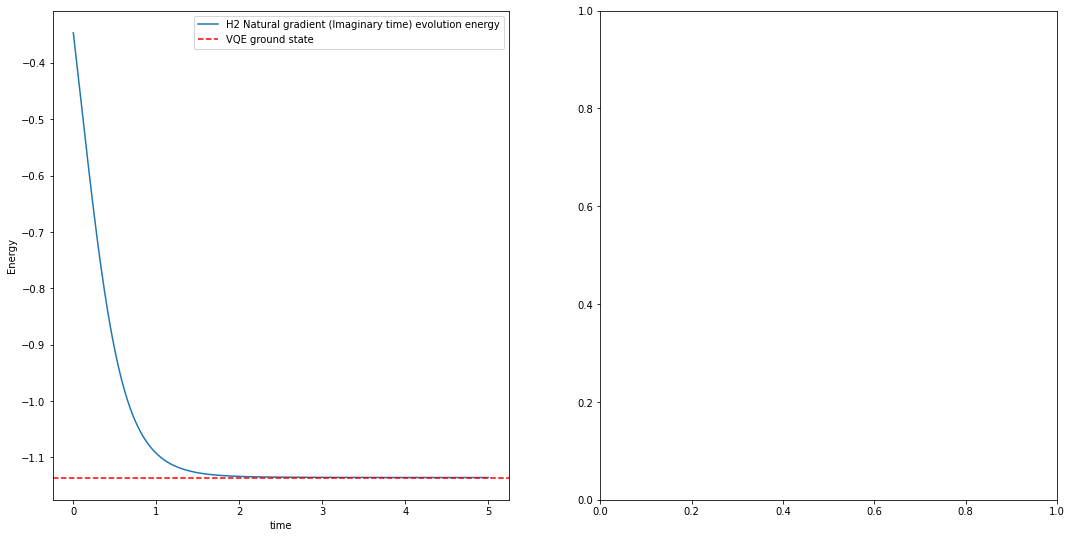

In [13]:
T = 5 #final time 
number_of_steps = T*100
dt=T/number_of_steps
numRep = 8  # number of parameters in the Universal ansatz used

#initial_angles = [np.pi,np.pi,np.pi,np.pi,np.pi,np.pi,np.pi,np.pi]
#initial_angles = [0,0,0,0,0,0,0,0]
initial_angles = np.random.rand(numRep)*np.pi

# simulator = Aer.get_backend('qasm_simulator')
simulator = Aer.get_backend('statevector_simulator')
sampler = CircuitSampler(backend=simulator)

angles_params=[]
value_dict={}

# Initialize parameters to initial angles
syms=symbols('θ_0:%d'%numRep)
for i,sym in enumerate(syms):
    par = Parameter(str(sym))
    angles_params.append(par)
    value_dict[par]= initial_angles[i]




list_of_energies=[]




def func(x,A,b):
	return np.dot(A,x)-b

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)



timesteps=np.linspace(0.,T,number_of_steps)
list_of_angles=np.zeros((len(timesteps)+1,numRep))

use_shots= False

list_of_angles[0]=np.asarray(initial_angles)

# Initialize the universal ansatz to represent H2
univ_ans = universal_ansatz(angles_params)
# Combine the qubit Hamiltonian and the universal ansatz
final_circuit = ~StateFn(qubit_op) @ CircuitStateFn(primitive=univ_ans, coeff=1.)

#timesteps=[1]
for it,t in enumerate(timesteps):

    # update dict
    value_dict={}
    for i,par in enumerate(angles_params):
        value_dict[par]=list_of_angles[it][i]

    # Measure energy
    energy = measure_H_energy(sampler, list_of_angles[it], qubit_op)  #measure natural gradient evo energy 
    list_of_energies.append(energy+res.nuclear_repulsion_energy) #add nuclear repulsion energy to final energy

    #MEAURE NATURAL GRADIENT

    nat_grad = NewNaturalGradient(grad_method='lin_comb', imaginary=False, qfi_method=LinCombFullmod(), regularization='ridge').convert(
    			operator=final_circuit, params=angles_params)
    
    
    # Compute d\Theta/dt for each of the 8 \Theta params.
    nat_grad_result = nat_grad.assign_parameters(value_dict).eval()
    dTheta = nat_grad_result * dt
    # update the angles \Theta
    list_of_angles[it+1] = np.add(list_of_angles[it], dTheta)
    #print('Natural gradient computed', nat_grad_result, 'new angles',angles_N)  
	



/home/gsilvi/miniforge3/envs/NEASQC4/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/gsilvi/miniforge3/envs/NEASQC4/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


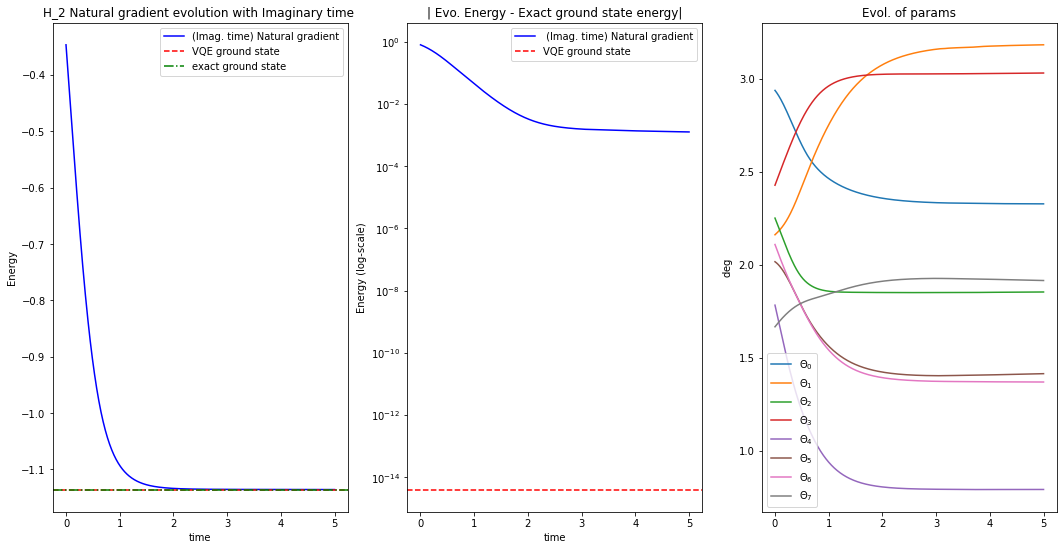

In [30]:


#PLOT
fig, (ax1, ax0, ax2) = plt.subplots(nrows=1, ncols=3,figsize=(18, 9))


ax1.set_title('H_2 Natural gradient evolution with Imaginary time ')
ax1.plot(timesteps,list_of_energies, color='blue',label='(Imag. time) Natural gradient')
ax1.axhline(vqe_energies,linestyle='--', color='red', label="VQE ground state")
ax1.axhline(exact_energy,linestyle='-.', color='green', label="exact ground state")
ax1.set_ylabel('Energy')
ax1.set_xlabel('time')
ax1.legend()


ax0.set_title('| Evo. Energy - Exact ground state energy|')
ax0.set_yscale('log')
ax0.plot(timesteps,list_of_energies-exact_energy, color='blue',label=' (Imag. time) Natural gradient')
ax0.axhline(vqe_energies-exact_energy,linestyle='--', color='red', label="VQE ground state")
ax0.set_ylabel('Energy (log-scale)')
ax0.set_xlabel('time')
ax0.set_yscale('log')
ax0.legend()


for i in range(numRep):
    ax2.plot(timesteps, list_of_angles[:-1,i], label="$\Theta_%s$"%str(i))
ax2.set_ylabel('$\deg$')
ax2.set_title('Evol. of params')
ax1.set_xlabel('time')
ax2.legend()


plt.savefig('AVQC_imaginary_time_evo_t'+str(T)+'.png')